In [19]:
import os
import numpy as np
import mne
from scipy import stats
import scipy.io
import h5py

from matplotlib import pyplot as plt
mne.set_log_level('error')

from utils.load import Load
from config.default import cfg

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
loader = Load(cfg)

In [3]:
# Change this one-by-one to process all subjects in the dataset
# Yeah, Im lazy, shut up!
subject_id = 0

In [4]:
raw_runs = loader.load_subject(subject_id = subject_id)

In [6]:
preprocessed_runs = raw_runs.copy()

drop_bad = False
for run in preprocessed_runs:
    run = run.resample(200)
    run = run.notch_filter(freqs=[60])
    if drop_bad:
        run = run.drop_channels(cfg['bad_channels'][cfg['subjects'][subject_id]])
        run = run.set_eeg_reference('average', projection=False)
        not_ROI = [x for x in cfg['not_ROI_channels'] if x not in cfg['bad_channels'][cfg['subjects'][subject_id]]]

        run = run.drop_channels(not_ROI)
    else:
        run = run.set_eeg_reference('average', projection=False)
        run = run.drop_channels(cfg['not_ROI_channels'])  
   

In [ ]:
# ORIG
preprocessed_runs[0].plot_psd()

In [ ]:
# Default
mu_plot = preprocessed_runs[0].copy().filter(l_freq=8, h_freq=12, method  = 'fir')
mu_plot.plot_psd()

In [ ]:
# Default
beta_plot = preprocessed_runs[0].copy().filter(l_freq=13, h_freq=25, method  = 'fir')
beta_plot.plot_psd()

In [14]:
'''
The features extracted are band power features for the
mu and beta bands
'''

method = 'fir'
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
both = []
mus = []
betas = []
for i in range(len(preprocessed_runs)):
    both.append(preprocessed_runs[i].copy().filter(l_freq=8, h_freq=25))
    # mus.append(preprocessed_runs[i].copy().filter(l_freq=8, h_freq=12, l_trans_bandwidth= l_trans_bandwidth, h_trans_bandwidth=h_trans_bandwidth,method = method))
    # betas.append(preprocessed_runs[i].copy().filter(l_freq=13, h_freq=25, l_trans_bandwidth= l_trans_bandwidth, h_trans_bandwidth=h_trans_bandwidth,method = method))

In [21]:
'''
The EEG data were band-pass filtered for the respective frequency
band, and the power was calculated by squaring each time
sample. 
Then the power was estimated in non-overlapping
0.25 s segments by averaging the power samples and applying
a centered moving average with a 0.75 s window length.
band power features were log-transformed
power shift compensation was applied, subtracting the mean band power over the last 25 s.
the band power features were epoched using 0.5 s pre-and 7 s post-cue.
'''


        
def get_feature(data, freq = 200):
    # Calculate power by squaring each time sample
    power_eeg_data = np.square(data)

    # Define segment parameters
    segment_length = int(0.025 * freq)
   
   
    power_eeg_data = power_eeg_data.reshape(power_eeg_data.shape[0], -1, segment_length)
    power_eeg_data = np.max(power_eeg_data, axis=-1)



    def centered_moving_average(data, window_size):
        half_window = window_size // 2
        cumsum = np.cumsum(data, axis=-1)
        cumsum[..., window_size:] = cumsum[..., window_size:] - cumsum[..., :-window_size]
        return (cumsum[..., window_size - 1:-window_size + 1] / window_size)
    power_eeg_data = centered_moving_average(power_eeg_data, 3)


    power_eeg_data = np.log(power_eeg_data)
    return power_eeg_data


In [22]:
sfreq = raw_runs[0].info['sfreq']


tmin = -0.5
tmax = 7



def get_baseline(data, length = 25): # 25s
    end = data[..., -int(length*sfreq):]
    end = get_feature(end, sfreq)
    return np.mean(end, axis=-1)



features = {'thumb': [], 'index': [], 'middle': [], 'ring': [], 'little': []}
for i in range(len(preprocessed_runs)):
    events, _ = mne.events_from_annotations(preprocessed_runs[i])

    # mu_baseline = get_baseline(mus[i].get_data())
    # beta_baseline = get_baseline(betas[i].get_data())
    both_baseline =get_baseline(both[i].get_data())

    for trigger in events:
        if trigger[-1] in [2, 3, 4, 5, 6]: # Drop 'No instruction' and 'Rest' events
            # Epoching
            # mu_time_baseline =  mus[i].get_data()[...,trigger[0]+int(baseline_min*sfreq):trigger[0]+int(baseline_max*sfreq)] 
            # beta_time_baseline =  betas[i].get_data()[...,trigger[0]+int(baseline_min*sfreq):trigger[0]+int(baseline_max*sfreq)]

            # mu_time_baseline = mu_time_baseline.mean(axis=-1)
            # beta_time_baseline = beta_time_baseline.mean(axis=-1)
          
            # mu_data = mus[i].get_data()[...,trigger[0]+int(tmin*sfreq):trigger[0]+int(tmax*sfreq)] 
            # beta_data = betas[i].get_data()[...,trigger[0]+int(tmin*sfreq):trigger[0]+int(tmax*sfreq)] 
            both_data = both[i].get_data()[...,trigger[0]+int(tmin*sfreq):trigger[0]+int(tmax*sfreq)]
            
            
            # mu_data -= mu_time_baseline[:,np.newaxis]
            # beta_data -= beta_time_baseline[:,np.newaxis]

          

            # feature extraction
            # mu_data = get_feature(mu_data, sfreq)
            # beta_data = get_feature(beta_data, sfreq)
            both_data = get_feature(both_data, sfreq)

            # power shift compensation
            # mu_data-=mu_baseline[:,np.newaxis]
            # beta_data-=beta_baseline[:,np.newaxis]
            both_data-=both_baseline[:,np.newaxis]


            # Format data
            data =  np.stack((mu_data, beta_data), axis=-1)
            
            # Append data to the right list
            #features[cfg['mapping'][trigger[-1]]].append(data)
            features[cfg['mapping'][trigger[-1]]].append(both_data)
 
for feature in features:
    features[feature] = np.array(features[feature])
    print(feature)
    print(features[feature].shape)

thumb
(50, 158, 296)
index
(50, 158, 296)
middle
(50, 158, 296)
ring
(50, 158, 296)
little
(50, 158, 296)


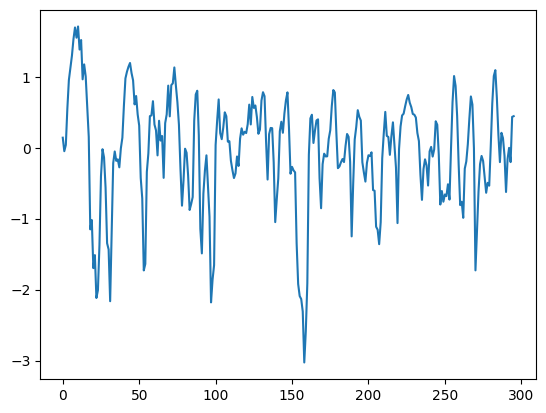

In [23]:
plt.plot(features['thumb'][0][0])

In [24]:
target_dir = 'features'
tag = 'more'
# Save the dictionary to an HDF5 file
file_path = os.path.join(target_dir, tag+'_'+cfg['subjects'][subject_id] + '.h5')
with h5py.File(file_path, 'w') as h5file:
    for key, value in features.items():
        h5file.create_dataset(key, data=value)